In [1]:
import pandas as pd #pandas to create small dataframes 
import numpy as np #Do aritmetic operations on arrays
import matplotlib # matplotlib: used to plot graphs
#matplotlib.use('nbagg') : matplotlib uses this protocall which makes plots more user intractive like zoom in and zoom out
matplotlib.use('nbagg')
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots 
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [2]:
train =pd.read_csv('E:/pgduoh/Project/ashrae-energy-prediction/train.csv')
test = pd.read_csv('E:/pgduoh/Project/ashrae-energy-prediction/test.csv')
weather_train = pd.read_csv('E:/pgduoh/Project/ashrae-energy-prediction/weather_train.csv')
weather_test = pd.read_csv('E:/pgduoh/Project/ashrae-energy-prediction/weather_test.csv')
building_metadata = pd.read_csv('E:/pgduoh/Project/ashrae-energy-prediction/building_metadata.csv')
train.name = 'train'
test.name = 'test'
weather_train.name = 'weather_train'
weather_test.name = 'weather_test'
building_metadata.name = 'building_metadata'

In [3]:
# Converting timestamp columns from all dataframes to datatime datatype
train['timestamp'] = pd.to_datetime(train['timestamp'])
test['timestamp'] = pd.to_datetime(test['timestamp'])
weather_train['timestamp'] = pd.to_datetime(weather_train['timestamp'])
weather_test['timestamp'] = pd.to_datetime(weather_test['timestamp'])

In [4]:
# Function reducing dataframe size to fit into memory
# source : https://www.kaggle.com/c/ashrae-energy-prediction/discussion
def reduce_memory_usage(dataframe, verbose=True): 
    starting_memory = dataframe.memory_usage().sum() / 1024**2
    numeric_types = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    for col in dataframe:
        data_type = dataframe[col].dtype
        if data_type in numeric_types:
            min_val = dataframe[col].min() #taking min and max value from each column
            max_val = dataframe[col].max()
            # assigning datatype as per the min and max value in column            
            if str(data_type)[:3] == 'int':
                if min_val > np.iinfo('int8').min and max_val < np.iinfo('int8').max:
                    dataframe[col] = dataframe[col].astype('int8')
                elif min_val > np.iinfo('int16').min and max_val < np.iinfo('int16').max:
                    dataframe[col] = dataframe[col].astype('int16')
                elif min_val > np.iinfo('int32').min and max_val < np.iinfo('int32').max:
                    dataframe[col] = dataframe[col].astype('int32')
                else:
                    dataframe[col] = dataframe[col].astype('int64') 
            else: 
                if min_val > np.finfo('float16').min and max_val < np.finfo('float16').max:
                    dataframe[col] = dataframe[col].astype('float16')
                elif min_val > np.finfo('float32').min and max_val < np.finfo('float32').max:
                    dataframe[col] = dataframe[col].astype('float32')
                else: 
                    dataframe[col] = dataframe[col].astype('float64') # useless line?
    end_memory = dataframe.memory_usage().sum() / 1024**2
    if verbose:
        #Checking how much memory reduced after applying this code        
        print('Memory usage decreased to {:.2f} mb ({:.2f}% decrease)'.format(end_memory, 100 * (starting_memory-end_memory) / starting_memory))

In [5]:
reduce_memory_usage(train)
reduce_memory_usage(test)
reduce_memory_usage(weather_train)
reduce_memory_usage(weather_test)
reduce_memory_usage(building_metadata)

Memory usage decreased to 289.19 mb (53.12% decrease)
Memory usage decreased to 596.49 mb (53.12% decrease)
Memory usage decreased to 3.07 mb (68.05% decrease)
Memory usage decreased to 6.08 mb (68.06% decrease)
Memory usage decreased to 0.03 mb (60.31% decrease)


In [6]:
# Merging all training data frames using left join
train_merged = train.merge(building_metadata, on='building_id', how='left')
train_merged = train_merged.merge(weather_train, on=['site_id','timestamp'], how='left')

In [7]:
train_merged.describe()

,building_id,meter,meter_reading,site_id,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
count,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,8088455.0,3506933.0,2.011944e+07,11390735.0,2.011596e+07,16467077.0,18984431.0,18767052.0,2.007242e+07
mean,7.992780e+02,6.624412e-01,2.117122e+03,7.992232e+00,1.077830e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,4.269133e+02,9.309921e-01,1.532356e+05,5.099060e+00,1.171424e+05,NaN,0.0,0.000000e+00,0.0,0.000000e+00,NaN,NaN,NaN,0.000000e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.830000e+02,1900.0,1.0,-2.890625e+01,0.0,-3.500000e+01,-1.0,968.0,0.0,0.000000e+00
25%,3.930000e+02,0.000000e+00,1.830000e+01,3.000000e+00,3.252700e+04,1951.0,1.0,8.601562e+00,0.0,0.000000e+00,0.0,1011.5,70.0,2.099609e+00
50%,8.950000e+02,0.000000e+00,7.877500e+01,9.000000e+00,7.270900e+04,1969.0,3.0,1.670312e+01,0.0,8.898438e+00,0.0,1016.0,180.0,3.099609e+00
75%,1.179000e+03,1.000000e+00,2.679840e+02,1.300000e+01,1.391130e+05,1993.0,6.0,2.409375e+01,4.0,1.609375e+01,0.0,1020.5,280.0,4.601562e+00
max,1.448000e+03,3.000000e+00,2.190470e+07,1.500000e+01,8.750000e+05,2017.0,26.0,4.718750e+01,9.0,2.609375e+01,343.0,1046.0,360.0,1.900000e+01


# Outlier removal

In [8]:
train_merged[train_merged['building_id']==1099]['meter_reading'].describe()
index= list(train_merged[train_merged['building_id']==1099].index)
train_merged.drop(index, axis=0, inplace=True)

In [9]:
# Outlier removal
train_merged[train_merged['building_id']==778]['meter_reading'].describe()
index= list(train_merged[train_merged['building_id']==778].index)
train_merged.drop(index, axis=0, inplace=True)

In [10]:
# #removing the data points with zero readings
train_merged.shape
zero_readings= list(train_merged[train_merged['meter_reading']==0.0].index)
print(len(zero_readings))
train_merged.drop(zero_readings, axis=0, inplace=True)
train_merged.shape

1866732


(18314942, 16)

New Features

In [11]:
#Creating fetures from timestamp column
train_merged['month'] = train_merged.timestamp.dt.month
train_merged['weekday'] = train_merged.timestamp.dt.weekday
train_merged['hour'] = train_merged.timestamp.dt.hour

In [12]:
# Creating if a date is holiday feature
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

df = pd.DataFrame()
df['Date'] = train_merged.timestamp.dt.date
# print(df['Date'].min())
# print(df['Date'].max())

cal = calendar()
holidays = cal.holidays(start=df['Date'].min(), end=df['Date'].max())

# df['Holiday'] = df['Date'].isin(holidays)
# print (df)
train_merged['is_holiday'] = df['Date'].isin(holidays)
train_merged.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,month,weekday,hour,is_holiday
45,46,0,2016-01-01,53.239700,0,Retail,9045,2016.0,NaN,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000,1,4,0,False
72,74,0,2016-01-01,43.001301,0,Parking,387638,1997.0,NaN,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000,1,4,0,False
91,93,0,2016-01-01,52.420601,0,Office,33370,1982.0,NaN,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000,1,4,0,False
103,105,0,2016-01-01,23.303600,1,Education,50623,NaN,5.0,3.800781,NaN,2.400391,NaN,1021.0,240.0,3.099609,1,4,0,False
104,106,0,2016-01-01,0.374600,1,Education,5374,NaN,4.0,3.800781,NaN,2.400391,NaN,1021.0,240.0,3.099609,1,4,0,False


In [13]:
# Since timestamp feature is broken into multiple features, it can be dropped now.
# train_merged.drop(['timestamp'], axis=1, inplace=True)

In [14]:
# sea_level_pressure, wind_direction, wind_speed columns are almost overlapping, these can aldo be dropped
train_merged.drop(['sea_level_pressure', 'wind_direction', 'wind_speed'], axis=1, inplace=True)

In [15]:
# y_train = train_merged['meter_reading']
# train_merged = train_merged.drop('meter_reading', axis=1)

In [16]:
# train_merged.head()
# train_merged.columns

In [17]:
# Label encoding primary use feature
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(train_merged.primary_use)
# LabelEncoder()
list(le.classes_)

train_merged.primary_use = le.transform(train_merged.primary_use)

In [18]:
train_merged.primary_use.unique() #total 16 type of buildings

array([11,  8,  6,  0,  4,  1,  9, 15,  2, 10,  3, 14,  7, 13,  5, 12])

In [19]:
# Encoding is_holiday feature to binary form
train_merged["is_holiday"] = train_merged["is_holiday"].astype(int)
train_merged.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,month,weekday,hour,is_holiday
45,46,0,2016-01-01,53.239700,0,11,9045,2016.0,NaN,25.000000,6.0,20.000000,NaN,1,4,0,0
72,74,0,2016-01-01,43.001301,0,8,387638,1997.0,NaN,25.000000,6.0,20.000000,NaN,1,4,0,0
91,93,0,2016-01-01,52.420601,0,6,33370,1982.0,NaN,25.000000,6.0,20.000000,NaN,1,4,0,0
103,105,0,2016-01-01,23.303600,1,0,50623,NaN,5.0,3.800781,NaN,2.400391,NaN,1,4,0,0
104,106,0,2016-01-01,0.374600,1,0,5374,NaN,4.0,3.800781,NaN,2.400391,NaN,1,4,0,0


Missing Vale Imputation

In [20]:
# Filling na values with mean 
year_built=train_merged.groupby(['site_id'])['year_built'].transform('mean')
train_merged['year_built'].fillna(year_built, inplace=True)

In [21]:
# Filling na values with mean 
floor_count=train_merged.groupby(['site_id'])['floor_count'].transform('mean')
floor_count
train_merged['floor_count'].fillna(floor_count, inplace=True)

In [22]:
# Filling na values with mean 
floor_count=1
floor_count
train_merged['floor_count'].fillna(floor_count, inplace=True)

In [23]:
year_built=train_merged['year_built'].median()
year_built
train_merged['year_built'].fillna(year_built, inplace=True)

In [24]:
air_temperature=train_merged.groupby(['site_id', 'weekday', 'month'])['air_temperature'].transform('median')
train_merged['air_temperature'].fillna(air_temperature, inplace=True)

In [25]:
cloud_coverage=train_merged.groupby(['site_id', 'weekday', 'month'])['cloud_coverage'].transform('median')
train_merged['cloud_coverage'].fillna(cloud_coverage, inplace=True)

In [26]:
dew_temperature=train_merged.groupby(['site_id', 'weekday', 'month'])['dew_temperature'].transform('median')
train_merged['dew_temperature'].fillna(dew_temperature, inplace=True)

In [27]:
precip_depth_1_hr=train_merged.groupby(['site_id', 'weekday', 'month'])['precip_depth_1_hr'].transform('median')
train_merged['precip_depth_1_hr'].fillna(precip_depth_1_hr, inplace=True)

In [28]:
cloud_coverage=train_merged['cloud_coverage'].median()
cloud_coverage
train_merged['cloud_coverage'].fillna(cloud_coverage, inplace=True)

In [29]:
precip_depth_1_hr=train_merged['precip_depth_1_hr'].median()
precip_depth_1_hr
train_merged['precip_depth_1_hr'].fillna(precip_depth_1_hr, inplace=True)

In [30]:
train_merged.isna().sum()

building_id          0
meter                0
timestamp            0
meter_reading        0
site_id              0
primary_use          0
square_feet          0
year_built           0
floor_count          0
air_temperature      0
cloud_coverage       0
dew_temperature      0
precip_depth_1_hr    0
month                0
weekday              0
hour                 0
is_holiday           0
dtype: int64

Normalization

In [31]:
# Normalizing columns using log1P normalization
train_merged['floor_count'] = np.log1p(train_merged['floor_count'])
train_merged['square_feet'] = np.log1p(train_merged['square_feet'])
# Normalizing columns using log1P normalization
train_merged['meter_reading'] = np.log1p(train_merged['meter_reading'])

In [32]:
train_merged.head()
train_merged['floor_count']

45          0.693359
72          0.693359
91          0.693359
103         1.791992
104         1.609375
              ...   
20216094    0.693359
20216095    0.693359
20216096    0.693359
20216098    0.693359
20216099    0.693359
Name: floor_count, Length: 18314942, dtype: float16

In [33]:
# y_train.head()

In [34]:
#baseline model
from sklearn.preprocessing import minmax_scale
train_merged['meter_reading'] = minmax_scale(train_merged['meter_reading'], feature_range=(0, 1))  # 0-1 scaling
y_pred= train_merged.groupby(['site_id', 'primary_use'])['meter_reading'].mean().reset_index()

In [35]:
train_merged[train_merged['site_id']==0].head(10)

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,month,weekday,hour,is_holiday
45,46,0,2016-01-01 00:00:00,0.312359,0,11,9.110078,2016.0,0.693359,25.000000,6.0,20.00000,0.0,1,4,0,0
72,74,0,2016-01-01 00:00:00,0.295995,0,8,12.867830,1997.0,0.693359,25.000000,6.0,20.00000,0.0,1,4,0,0
91,93,0,2016-01-01 00:00:00,0.311168,0,6,10.415443,1982.0,0.693359,25.000000,6.0,20.00000,0.0,1,4,0,0
2321,20,0,2016-01-01 01:00:00,0.354524,0,0,11.610714,1977.0,0.693359,24.406250,4.0,21.09375,-1.0,1,4,1,0
2346,46,0,2016-01-01 01:00:00,0.312947,0,11,9.110078,2016.0,0.693359,24.406250,4.0,21.09375,-1.0,1,4,1,0
4639,46,0,2016-01-01 02:00:00,0.314686,0,11,9.110078,2016.0,0.693359,22.796875,2.0,21.09375,0.0,1,4,2,0
6938,46,0,2016-01-01 03:00:00,0.312947,0,11,9.110078,2016.0,0.693359,21.093750,2.0,20.59375,0.0,1,4,3,0
6987,96,0,2016-01-01 03:00:00,0.276455,0,4,12.210732,2006.0,0.693359,21.093750,2.0,20.59375,0.0,1,4,3,0
9234,46,0,2016-01-01 04:00:00,0.312947,0,11,9.110078,2016.0,0.693359,20.000000,2.0,20.00000,-1.0,1,4,4,0
11530,46,0,2016-01-01 05:00:00,0.314111,0,11,9.110078,2016.0,0.693359,19.406250,4.0,19.40625,0.0,1,4,5,0


In [36]:
y_pred[y_pred['site_id']==0].head(10)

,site_id,primary_use,meter_reading
0,0,0,0.499385
1,0,1,0.439734
2,0,4,0.458970
3,0,6,0.420130
4,0,7,0.360783
5,0,8,0.349494
6,0,11,0.330884


In [37]:
#baseline model - 2
y_pred2= train_merged.groupby(['site_id', 'primary_use','floor_count','year_built'])['meter_reading'].mean().reset_index()

In [38]:
y_pred2[y_pred2['site_id']==0].head(10)

,site_id,primary_use,floor_count,year_built,meter_reading
0,0,0,0.693359,1968.0,0.405848
1,0,0,0.693359,1970.0,0.469247
2,0,0,0.693359,1975.0,0.575072
3,0,0,0.693359,1977.0,0.484971
4,0,0,0.693359,1985.0,0.530279
5,0,0,0.693359,1986.0,0.343047
6,0,0,0.693359,1989.0,0.565235
7,0,0,0.693359,1991.0,0.235190
8,0,0,0.693359,1996.0,0.473421
9,0,0,0.693359,1997.0,0.557202


In [39]:
train_merged=train_merged.sort_values(by='timestamp')

In [40]:
X_train, X_cv= train_test_split(train_merged, test_size=0.20, shuffle=False)

In [41]:
#y_pred for baseline
y_pred.rename(columns={"meter_reading": "y_pred_base"}, inplace=True)
X_train= X_train.merge(y_pred, on=['site_id', 'primary_use'], how='left')
X_cv= X_cv.merge(y_pred,on=['site_id', 'primary_use'], how='left')

In [42]:
#rsmle score for baseline model
import math
from sklearn.metrics import mean_squared_error
rmse_base_tr=math.sqrt(mean_squared_error(X_train['meter_reading'], X_train['y_pred_base']))
rmse_base_cv=math.sqrt(mean_squared_error(X_cv['meter_reading'], X_cv['y_pred_base']))
print("RMSE for baseline model for train data:", rmse_base_tr)
print("RMSE for baseline model for cv data:", rmse_base_cv)

RMSE for baseline model for train data: 0.11738501037342629
RMSE for baseline model for cv data: 0.12000189264364598


In [43]:
rmsle_base_tr= np.sqrt(mean_squared_log_error(X_train['meter_reading'], X_train['y_pred_base']))
rmsle_base_cv= np.sqrt(mean_squared_log_error(X_cv['meter_reading'], X_cv['y_pred_base']))
print("RMSLE for baseline model for train data:", rmsle_base_tr)
print("RMSLE for baseline model for cv data:", rmsle_base_cv)

RMSLE for baseline model for train data: 0.0878098
RMSLE for baseline model for cv data: 0.08995653


In [47]:
X_train.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,month,weekday,hour,is_holiday
0,46,0,2016-01-01,3.993413,0,11,9.110078,2016.0,0.693359,25.000000,6.0,20.000000,0.0,1,4,0,0
1,1164,0,2016-01-01,5.492349,13,6,12.427046,1965.0,0.693359,-8.296875,8.0,-12.203125,0.0,1,4,0,0
2,1163,2,2016-01-01,6.482104,13,8,11.337619,1965.0,0.693359,-8.296875,8.0,-12.203125,0.0,1,4,0,0
3,1163,1,2016-01-01,1.526643,13,8,11.337619,1965.0,0.693359,-8.296875,8.0,-12.203125,0.0,1,4,0,0
4,1163,0,2016-01-01,3.970292,13,8,11.337619,1965.0,0.693359,-8.296875,8.0,-12.203125,0.0,1,4,0,0


In [53]:
X_cv.drop(['y_pred_base_x'], axis=1, inplace=True)
X_cv.drop(['y_pred_base_y'], axis=1, inplace=True)

In [55]:
#y_pred for baseline2
# X_train.drop(['y_pred_base_x'], axis=1, inplace=True)
# X_cv.drop(['y_pred_base'], axis=1, inplace=True)
y_pred2.rename(columns={"meter_reading": "y_pred_base"}, inplace=True)
X_train= X_train.merge(y_pred2, on=['site_id', 'primary_use','floor_count','year_built'], how='left')
X_cv= X_cv.merge(y_pred2,on=['site_id', 'primary_use','floor_count','year_built'], how='left')

In [52]:
X_cv.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,month,weekday,hour,is_holiday,y_pred_base_x,y_pred_base_y
0,288,0,2016-10-22 10:00:00,0.271547,2,1,9.281172,2005.0,0.693359,25.000000,0.0,5.601562,0.0,10,5,10,0,0.337939,0.217146
1,287,1,2016-10-22 10:00:00,0.070945,2,6,10.425668,1956.0,0.693359,25.000000,0.0,5.601562,0.0,10,5,10,0,0.315714,0.185412
2,287,0,2016-10-22 10:00:00,0.274527,2,6,10.425668,1956.0,0.693359,25.000000,0.0,5.601562,0.0,10,5,10,0,0.315714,0.185412
3,299,0,2016-10-22 10:00:00,0.279598,3,0,12.782689,2014.0,0.693359,12.796875,4.0,6.101562,0.0,10,5,10,0,0.351866,0.383441
4,286,1,2016-10-22 10:00:00,0.343838,2,4,10.399463,1935.0,0.693359,25.000000,0.0,5.601562,0.0,10,5,10,0,0.353913,0.287405


In [56]:
rmsle_base_tr= np.sqrt(mean_squared_log_error(X_train['meter_reading'], X_train['y_pred_base']))
rmsle_base_cv= np.sqrt(mean_squared_log_error(X_cv['meter_reading'], X_cv['y_pred_base']))
print("RMSLE for baseline model for train data:", rmsle_base_tr)
print("RMSLE for baseline model for cv data:", rmsle_base_cv)

RMSLE for baseline model for train data: 0.077856146
RMSLE for baseline model for cv data: 0.079828836


In [57]:
# Dropping columns which are not required for model build
Y_train=X_train['meter_reading']
Y_cv=X_cv['meter_reading']
X_train.drop(['meter_reading', 'y_pred_base'], axis=1, inplace=True)
X_cv.drop(['meter_reading', 'y_pred_base'], axis=1, inplace=True)
Y_train.head()

0    0.312359
1    0.429606
2    0.507025
3    0.119407
4    0.310550
Name: meter_reading, dtype: float32

In [63]:
Y_cv.min()

0.0

In [59]:
# Since timestamp feature is broken into multiple features, it can be dropped now.
X_train.drop(['timestamp'], axis=1, inplace=True)
X_cv.drop(['timestamp'], axis=1, inplace=True)

In [54]:
# Decision Tree Regressor
cv_RMSLE=[]
depthofTree=[3,5,7,9,11,15]
for d in depthofTree:
  dtr=DecisionTreeRegressor(max_depth=d)
  dtr.fit(X_train,Y_train)
  dtr_cv=dtr.predict(X_cv)
  from sklearn.preprocessing import minmax_scale
  Y_cv = minmax_scale(Y_cv, feature_range=(0, 1))  # 0-1 scaling
  dtr_cv = minmax_scale(dtr_cv, feature_range=(0, 1))  # 0-1 scaling
  cv_RMSLE.append(np.sqrt(mean_squared_log_error(Y_cv, dtr_cv)))
#   cv_RMSLE.append(mean_squared_log_error(Y_cv, dtr_cv,squared=False))
  print("RMSLE for max_depth:", d,'is',(np.sqrt(mean_squared_log_error(Y_cv, dtr_cv))))

RMSLE for max_depth: 3 is 0.3185885218670067
RMSLE for max_depth: 5 is 0.29871285578640794
RMSLE for max_depth: 7 is 0.27172448736830107
RMSLE for max_depth: 9 is 0.24579788850332715
RMSLE for max_depth: 11 is 0.22157159786432032
RMSLE for max_depth: 15 is 0.19583704982075106


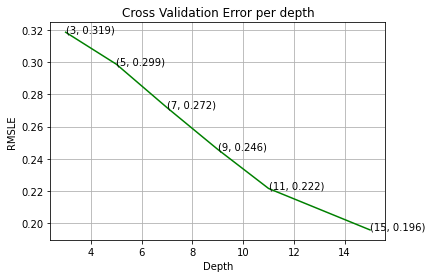

In [55]:
# finding best depth for DTR
d_min = np.argmin(cv_RMSLE)
fig, ax = plt.subplots()
ax.plot(depthofTree, cv_RMSLE,c='g')
for i, txt in enumerate(np.round(cv_RMSLE,3)):
  ax.annotate((depthofTree[i],np.round(txt,3)), (depthofTree[i],cv_RMSLE[i]))
plt.grid()
plt.title("Cross Validation Error per depth")
plt.xlabel("Depth")
plt.ylabel("RMSLE")
plt.show()

In [64]:
#  As the plot for depth = 15 DTR gives min cross validation error
dtr=DecisionTreeRegressor(max_depth=15,random_state=5)
dtr.fit(X_train,Y_train)
dtr_pred_tr=dtr.predict(X_train)
dtr_pred_cv=dtr.predict(X_cv)
from sklearn.preprocessing import minmax_scale
dtr_pred_cv = minmax_scale(dtr_pred_cv, feature_range=(0, 1))  # 0-1 scaling
dtr_pred_tr = minmax_scale(dtr_pred_tr, feature_range=(0, 1))  # 0-1 scaling
print("Train rmsle for max_depth: 15",'is',np.sqrt(mean_squared_log_error(Y_train, dtr_pred_tr)))
print("CV rmsle for max_depth: 15",'is',np.sqrt(mean_squared_log_error(Y_cv, dtr_pred_cv)))

Train rmsle for max_depth: 15 is 0.042981773299078076
CV rmsle for max_depth: 15 is 0.057975262262512504


In [ ]:
# !pip3 install lightgbm

In [61]:
# LGBM Random Forest Regressor
import lightgbm as lgb
cv_RMSLE=[]
estimators=[75,150,500,1000,2000]
for i in estimators:
  rfr=lgb.LGBMRegressor(boosting_type='rf',objective='regression', n_estimators=i, n_jobs=-1,subsample=0.8,feature_fraction=0.8,bagging_freq=1)
  rfr.fit(X_train,Y_train)
  rfr_cv=rfr.predict(X_cv)
  cv_RMSLE.append(np.sqrt(mean_squared_log_error(Y_cv, rfr_cv)))
#   cv_RMSLE.append(mean_squared_log_error(Y_cv, dtr_cv,squared=False))
  print("RMSLE for Estimator:", i,'is',(np.sqrt(mean_squared_log_error(Y_cv, rfr_cv))))

RMSLE for Estimator: 75 is 0.2848037200532103
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
RMSLE for Estimator: 150 is 0.28519136640854437
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
RMSLE for Estimator: 500 is 0.28544401025115324
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
RMSLE for Estimator: 1000 is 0.2856014332380486
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fra

In [67]:
# LGBM Random Forest Regressor
import lightgbm as lgb
cv_RMSLE=[]
estimators=[500]
for i in estimators:
  rfr=lgb.LGBMRegressor(boosting_type='gbdt',objective='regression', n_estimators=i, n_jobs=-1,subsample=0.8,feature_fraction=0.8,bagging_freq=1)
  rfr.fit(X_train,Y_train)
  rfr_cv=rfr.predict(X_cv)
  from sklearn.preprocessing import minmax_scale
  rfr_cv = minmax_scale(rfr_cv, feature_range=(0, 1))  # 0-1 scaling
  cv_RMSLE.append(np.sqrt(mean_squared_log_error(Y_cv, rfr_cv)))
#   cv_RMSLE.append(mean_squared_log_error(Y_cv, dtr_cv,squared=False))
  print("RMSLE for Estimator:", i,'is',(np.sqrt(mean_squared_log_error(Y_cv, rfr_cv))))

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
RMSLE for Estimator: 500 is 0.0543564699807453


In [60]:
from sklearn.feature_selection import mutual_info_classif
feat_importance = dtr.tree_.compute_feature_importances(normalize=False)
print("feat importance = " + str(feat_importance))

feat importance = [0.44239564 0.32748055 0.050455   0.11882554 1.39948091 0.10813705
 0.04084247 0.10656163 0.00416335 0.02182996 0.00235916 0.03960899
 0.00617195 0.03478979 0.        ]
